# Сегментация изображений

## Задание

Необходимо подготовить датасет https://www.kaggle.com/olekslu/makeup-lips-segmentation-28k-samples для обучения модели на сегментацию губ
Обучить модель на выбор из segmentation_models_pytorch

In [1]:
# Устанавливаем библиотеку segmentation_models_pytorch, если она не установлена
!pip install -q segmentation-models-pytorch

Названия столбцов metadata:
Index(['filename', 'width', 'height', 'class', 'xmin', 'ymin', 'xmax', 'ymax',
       'mask'],
      dtype='object')
Эпоха 1/10, Потери: Тренировка - 0.0203, Валидация - 0.0029
Эпоха 2/10, Потери: Тренировка - 0.0033, Валидация - 0.0029
Эпоха 3/10, Потери: Тренировка - 0.0031, Валидация - 0.0030
Эпоха 4/10, Потери: Тренировка - 0.0027, Валидация - 0.0027
Эпоха 5/10, Потери: Тренировка - 0.0028, Валидация - 0.0026
Эпоха 6/10, Потери: Тренировка - 0.0027, Валидация - 0.0027
Эпоха 7/10, Потери: Тренировка - 0.0024, Валидация - 0.0022
Эпоха 8/10, Потери: Тренировка - 0.0025, Валидация - 0.0023
Эпоха 9/10, Потери: Тренировка - 0.0022, Валидация - 0.0022
Эпоха 10/10, Потери: Тренировка - 0.0024, Валидация - 0.0023


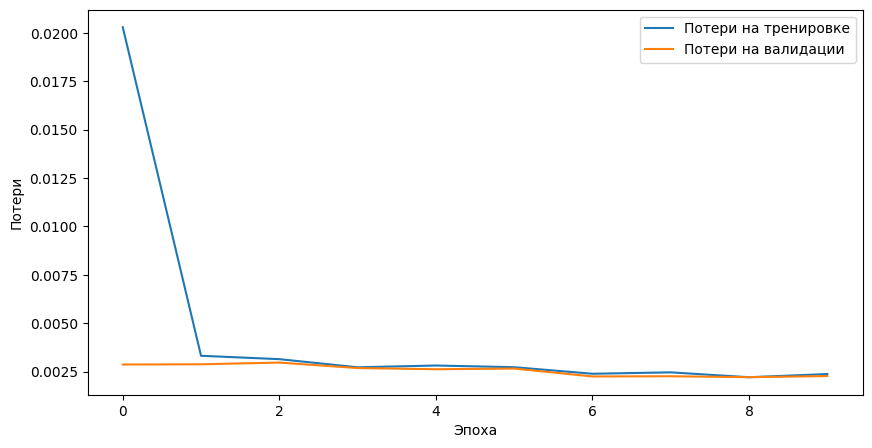

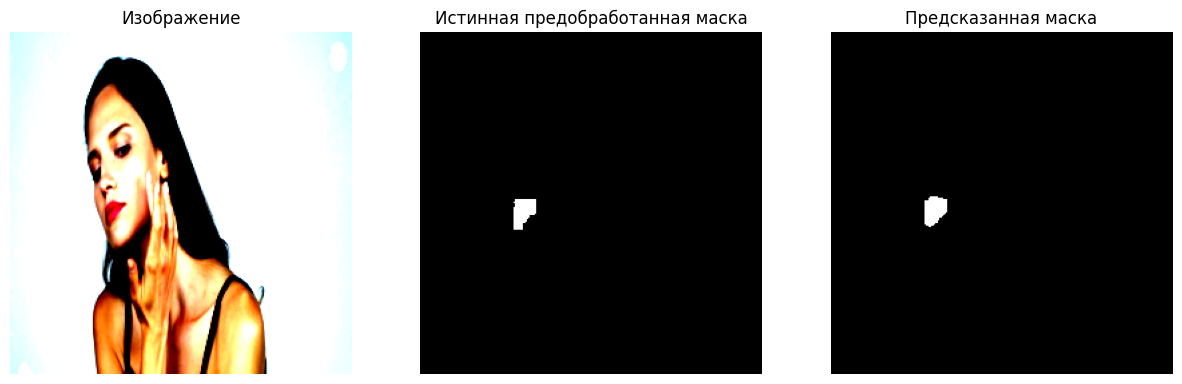

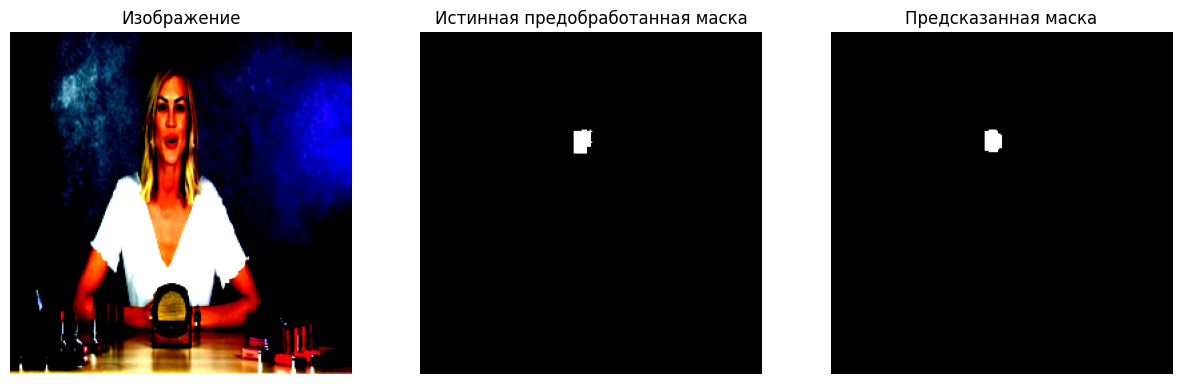

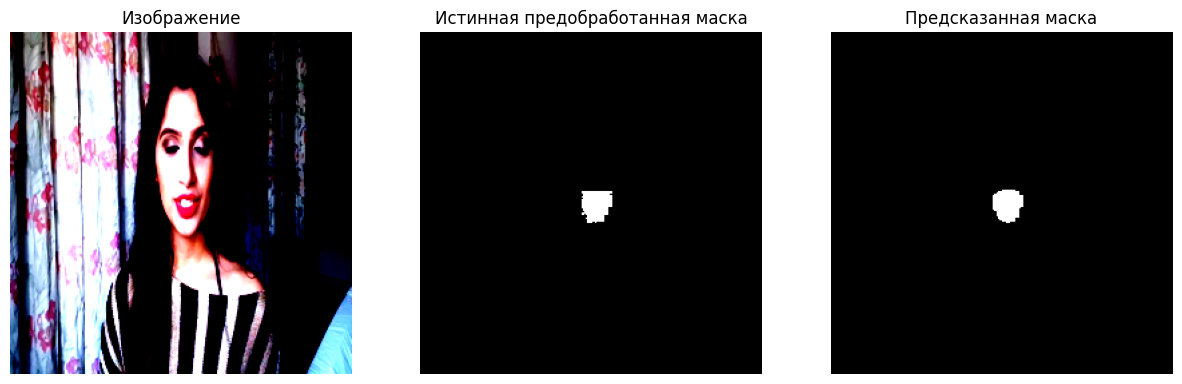

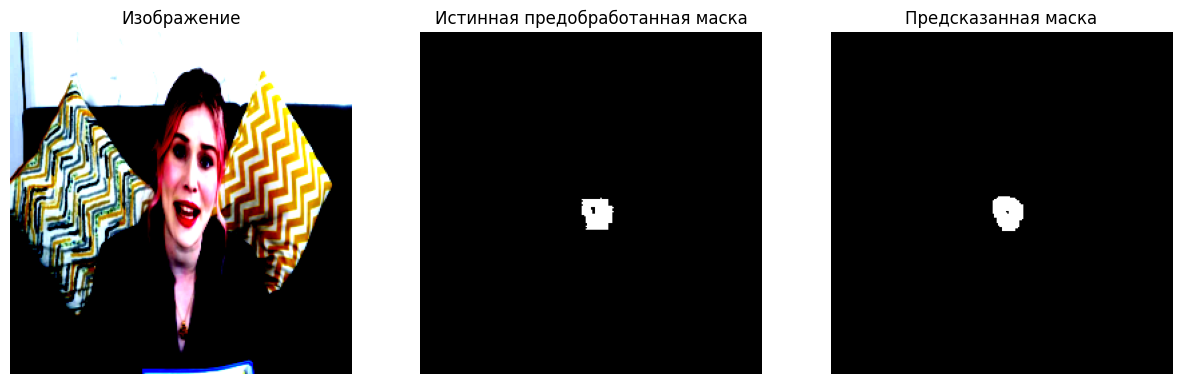

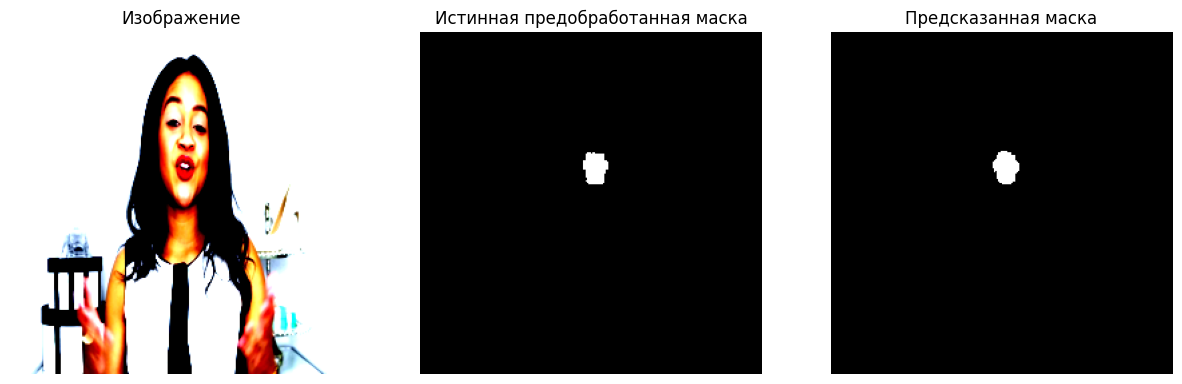

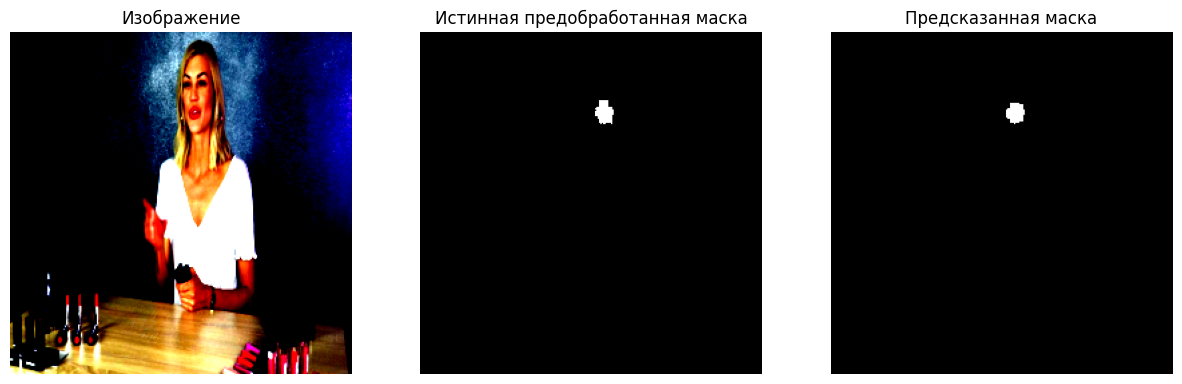

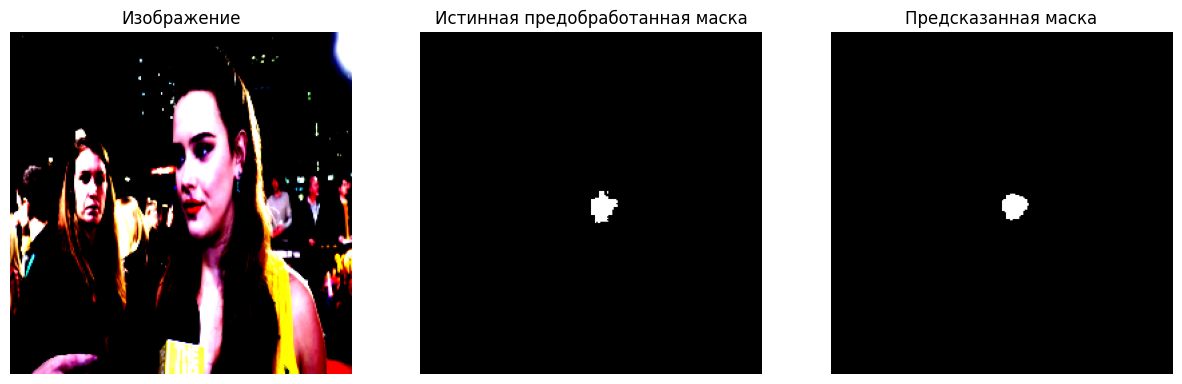

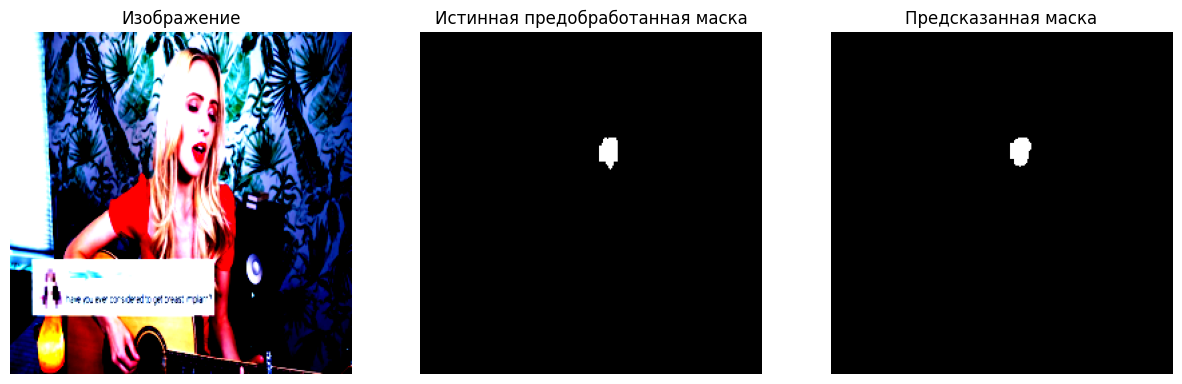

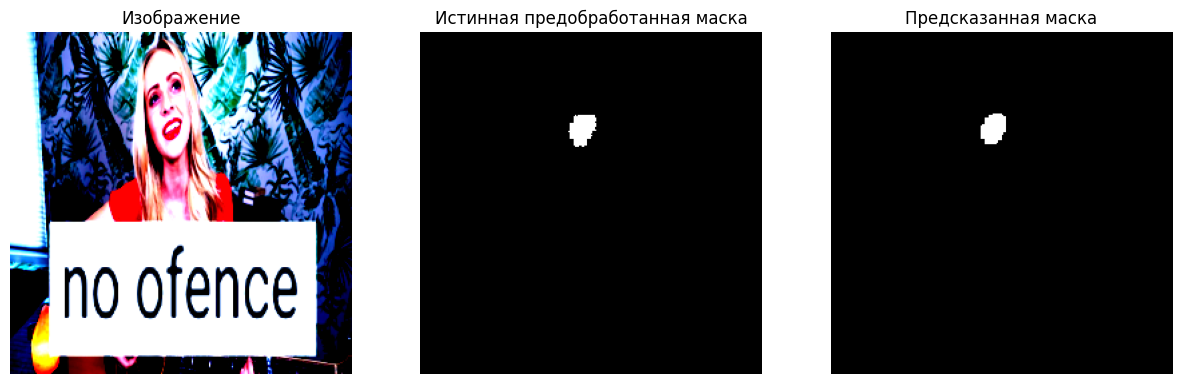

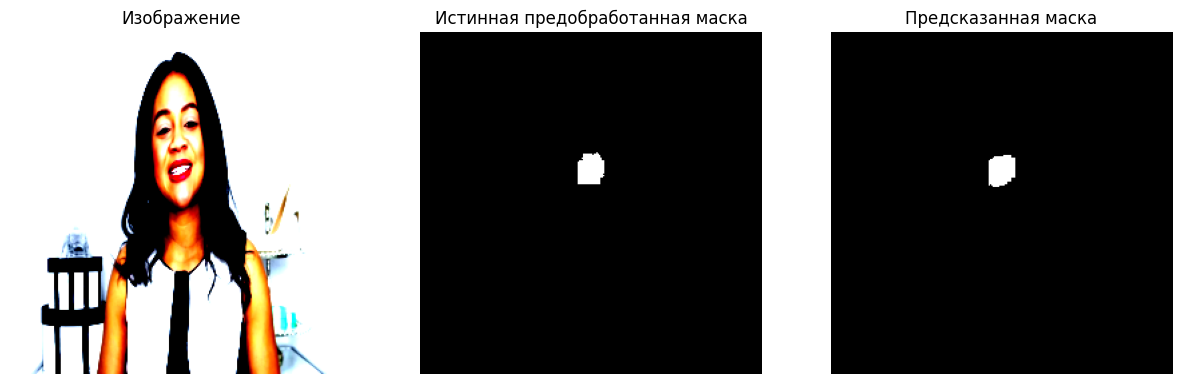

In [18]:
# Импортируем необходимые библиотеки
import os  # Для работы с файловой системой
import numpy as np  # Для работы с массивами данных
import pandas as pd  # Для работы с табличными данными (например, с CSV-файлами)
from PIL import Image  # Для загрузки и обработки изображений
from sklearn.model_selection import train_test_split  # Для разделения данных на обучающую и тестовую выборки
from torch.utils.data import DataLoader, Dataset  # Для создания и загрузки датасетов в PyTorch
import torchvision.transforms as transforms  # Для применения трансформаций к изображениям
import segmentation_models_pytorch as smp  # Для использования готовых моделей сегментации из библиотеки
import torch  # Основная библиотека для работы с нейросетями
import matplotlib.pyplot as plt  # Для построения графиков и визуализации изображений

# Указываем путь к датасету, который находится на Kaggle
dataset_path = 'C:/Users/pavel/Downloads/Makeup. Pixel Perfect Lips Segmentation/set-lipstick-original'

# Загружаем файл с метаданными, содержащий информацию о путях к изображениям и маскам
metadata = pd.read_csv(os.path.join(dataset_path, 'list.csv'))

# Проверяем названия столбцов в метаданных, чтобы убедиться, что все данные загружены правильно
print("Названия столбцов metadata:")
print(metadata.columns)

# Сбрасываем индексы для таблицы metadata, чтобы избежать ошибок с некорректными индексами
metadata.reset_index(drop=True, inplace=True)

# Определяем класс, который будет представлять наш пользовательский датасет
class LipSegmentationDataset(Dataset):
    def __init__(self, metadata, image_dir, mask_dir, image_transform=None, mask_transform=None):
        """
        Инициализация класса LipSegmentationDataset.

        Аргументы:
        - metadata: таблица с метаданными, которая содержит пути к изображениям и маскам.
        - image_dir: директория, в которой хранятся изображения.
        - mask_dir: директория, в которой хранятся маски.
        - image_transform: трансформации, которые нужно применить к изображениям.
        - mask_transform: трансформации, которые нужно применить к маскам.
        """
        self.metadata = metadata  # Сохраняем метаданные в объекте класса
        self.image_dir = image_dir  # Сохраняем путь к директории с изображениями
        self.mask_dir = mask_dir  # Сохраняем путь к директории с масками
        self.image_transform = image_transform  # Сохраняем трансформации для изображений
        self.mask_transform = mask_transform  # Сохраняем трансформации для масок

    def __len__(self):
        """
        Возвращаем количество образцов в датасете.

        Это метод, который необходим для работы с DataLoader.
        """
        return len(self.metadata)  # Возвращаем длину таблицы с метаданными

    def __getitem__(self, idx):
        """
        Возвращаем изображение и соответствующую маску по индексу.

        Аргументы:
        - idx: индекс элемента, который нужно вернуть.

        Возвращает:
        - Изображение и маска, которые будут использоваться для обучения модели.
        """
        # Получаем путь к изображению и маске, используя индекс
        img_name = os.path.join(self.image_dir, self.metadata.iloc[idx]['filename'])
        mask_name = os.path.join(self.mask_dir, self.metadata.iloc[idx]['mask'])

        # Проверяем, существуют ли файлы изображения и маски
        if not os.path.exists(img_name) or not os.path.exists(mask_name):
            # Если файл не найден, пытаемся загрузить следующий элемент в датасете
            return self.__getitem__((idx + 1) % len(self.metadata))

        # Загружаем изображение и конвертируем в RGB
        image = Image.open(img_name).convert("RGB")
        # Загружаем маску и конвертируем в градации серого (L)
        mask = Image.open(mask_name).convert("L")

        # Применяем трансформации, если они указаны
        if self.image_transform:
            image = self.image_transform(image)
        if self.mask_transform:
            mask = self.mask_transform(mask)

        # Преобразуем маску в массив NumPy и выполняем бинаризацию
        mask = np.array(mask)
        mask = np.where(mask > 0, 1, 0).astype(np.float32)

        # Преобразуем маску в тензор PyTorch и добавляем измерение канала
        mask = torch.tensor(mask, dtype=torch.float32).unsqueeze(0)

        return image, mask  # Возвращаем изображение и маску

# Определяем трансформации для изображений и масок
image_transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Изменяем размер изображений до 256x256 пикселей
    transforms.ToTensor(),  # Преобразуем изображение в тензор
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Нормализуем изображение
])

mask_transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Изменяем размер масок до 256x256 пикселей
])

# Разделяем датасет на обучающую и валидационную выборки в пропорции 80/20
train_metadata, val_metadata = train_test_split(metadata, test_size=0.2, random_state=42)

# Создаём объекты для загрузки данных в обучающую и валидационную выборки
train_dataset = LipSegmentationDataset(
    metadata=train_metadata,  # Метаданные для обучающей выборки
    image_dir=os.path.join(dataset_path, '720p'),  # Путь к изображениям
    mask_dir=os.path.join(dataset_path, 'mask'),  # Путь к маскам
    image_transform=image_transform,  # Трансформации для изображений
    mask_transform=mask_transform  # Трансформации для масок
)

val_dataset = LipSegmentationDataset(
    metadata=val_metadata,  # Метаданные для валидационной выборки
    image_dir=os.path.join(dataset_path, '720p'),  # Путь к изображениям
    mask_dir=os.path.join(dataset_path, 'mask'),  # Путь к маскам
    image_transform=image_transform,  # Трансформации для изображений
    mask_transform=mask_transform  # Трансформации для масок
)

# Создаём загрузчики данных с размером батча 16 для обучения и валидации
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=4)

# Определяем модель U-Net с предобученным энкодером ResNet34
model = smp.Unet(
    encoder_name="resnet34",  # Используем предобученную модель ResNet34 в качестве энкодера
    encoder_weights="imagenet",  # Загружаем веса, предобученные на ImageNet
    in_channels=3,  # Количество каналов на входе (RGB изображение имеет 3 канала)
    classes=1  # Количество классов на выходе (1 класс, так как это задача бинарной сегментации)
)

# Переносим модель на графический процессор (если он доступен)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)  # Переносим модель на GPU

# Определяем функцию потерь - бинарную кросс-энтропию с логитами
loss_fn = torch.nn.BCEWithLogitsLoss()

# Определяем оптимизатор - используем Adam для быстрого обучения
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Определяем функцию для обучения модели
def train_model(model, train_loader, val_loader, loss_fn, optimizer, num_epochs=10):
    """
    Функция для обучения модели.

    Аргументы:
    - model: модель, которую нужно обучить.
    - train_loader: загрузчик данных для обучающей выборки.
    - val_loader: загрузчик данных для валидационной выборки.
    - loss_fn: функция потерь, которая будет использоваться.
    - optimizer: оптимизатор, который будет использоваться.
    - num_epochs: количество эпох для обучения.
    """
    train_losses = []  # Список для хранения значений функции потерь на обучающей выборке
    val_losses = []  # Список для хранения значений функции потерь на валидационной выборке

    for epoch in range(num_epochs):  # Цикл по каждой эпохе
        model.train()  # Устанавливаем модель в режим обучения
        train_loss = 0  # Обнуляем значение функции потерь для обучающей выборки

        for images, masks in train_loader:  # Цикл по каждому батчу данных в обучающей выборке
            images = images.to(device)  # Переносим изображения на GPU
            masks = masks.to(device)  # Переносим маски на GPU

            optimizer.zero_grad()  # Обнуляем градиенты оптимизатора
            outputs = model(images)  # Прогоняем изображения через модель

            # Изменяем размер выходов модели для соответствия маскам
            if outputs.shape[-2:] != masks.shape[-2:]:
                outputs = torch.nn.functional.interpolate(outputs, size=masks.shape[-2:], mode="bilinear", align_corners=False)

            loss = loss_fn(outputs, masks)  # Вычисляем значение функции потерь
            loss.backward()  # Вычисляем градиенты
            optimizer.step()  # Обновляем параметры модели

            train_loss += loss.item()  # Добавляем значение функции потерь в суммарный показатель

        train_loss /= len(train_loader)  # Среднее значение функции потерь за одну эпоху
        train_losses.append(train_loss)  # Добавляем значение функции потерь в список

        model.eval()  # Устанавливаем модель в режим валидации
        val_loss = 0  # Обнуляем значение функции потерь для валидационной выборки

        with torch.no_grad():  # Отключаем автоматическое вычисление градиентов
            for images, masks in val_loader:  # Цикл по каждому батчу данных в валидационной выборке
                images = images.to(device)  # Переносим изображения на GPU
                masks = masks.to(device)  # Переносим маски на GPU

                outputs = model(images)  # Прогоняем изображения через модель

                # Изменяем размер выходов модели для соответствия маскам
                if outputs.shape[-2:] != masks.shape[-2:]:
                    outputs = torch.nn.functional.interpolate(outputs, size=masks.shape[-2:], mode="bilinear", align_corners=False)

                loss = loss_fn(outputs, masks)  # Вычисляем значение функции потерь
                val_loss += loss.item()  # Добавляем значение функции потерь в суммарный показатель

        val_loss /= len(val_loader)  # Среднее значение функции потерь за одну эпоху
        val_losses.append(val_loss)  # Добавляем значение функции потерь в список

        # Выводим статистику за каждую эпоху
        print(f"Эпоха {epoch+1}/{num_epochs}, Потери: Тренировка - {train_loss:.4f}, Валидация - {val_loss:.4f}")

    # Возвращаем значения потерь для построения графиков
    return train_losses, val_losses

# Запускаем обучение модели на 10 эпохах
train_losses, val_losses = train_model(model, train_loader, val_loader, loss_fn, optimizer, num_epochs=10)

# Визуализируем результаты обучения
plt.figure(figsize=(10, 5))  # Устанавливаем размер графика
plt.plot(train_losses, label='Потери на тренировке')  # Строим график потерь на обучении
plt.plot(val_losses, label='Потери на валидации')  # Строим график потерь на валидации
plt.xlabel('Эпоха')  # Подпись оси X
plt.ylabel('Потери')  # Подпись оси Y
plt.legend()  # Добавляем легенду
plt.show()  # Показываем график

# Визуализируем несколько примеров изображений и соответствующих им масок из валидационной выборки
def visualize_predictions(model, loader, device, num_images=5):
    """
    Функция для визуализации предсказанных масок моделью.

    Аргументы:
    - model: обученная модель, которая будет использоваться для предсказаний.
    - loader: загрузчик данных, из которого будут взяты изображения.
    - device: устройство, на котором находится модель (CPU или GPU).
    - num_images: количество изображений для визуализации.
    """
    model.eval()  # Переводим модель в режим оценки
    images_shown = 0  # Счетчик отображенных изображений

    with torch.no_grad():  # Отключаем вычисление градиентов
        for images, masks in loader:  # Проходим по данным из загрузчика
            images = images.to(device)  # Переносим изображения на GPU
            masks = masks.to(device)  # Переносим маски на GPU

            outputs = model(images)  # Прогоняем изображения через модель
            preds = torch.sigmoid(outputs) > 0.5  # Применяем сигмоиду и пороговое значение 0.5 для получения бинарных масок

            for i in range(len(images)):  # Проходим по каждому изображению в батче
                if images_shown >= num_images:  # Если показано достаточно изображений, завершаем функцию
                    return

                # Переносим данные на CPU и преобразуем их в формат для отображения
                image = images[i].cpu().permute(1, 2, 0).numpy()
                mask = masks[i].cpu().squeeze().numpy()
                pred = preds[i].cpu().squeeze().numpy()

                # Отображаем изображение, истинную маску и предсказанную моделью маску
                fig, ax = plt.subplots(1, 3, figsize=(15, 5))
                ax[0].imshow(image)
                ax[0].set_title("Изображение")
                ax[0].axis("off")

                ax[1].imshow(mask, cmap="gray")
                ax[1].set_title("Истинная предобработанная маска")
                ax[1].axis("off")

                ax[2].imshow(pred, cmap="gray")
                ax[2].set_title("Предсказанная маска")
                ax[2].axis("off")

                plt.show()  # Показываем график

                images_shown += 1  # Увеличиваем счетчик отображенных изображений

# Визуализируем 5 предсказаний
visualize_predictions(model, val_loader, device, num_images=10)



Модель демонстрирует хорошую производительность на тренировочных и валидационных данных с устойчивым снижением потерь. Несмотря на это, небольшие признаки переобучения в конце обучения требуют внимания. Устойчивость к переобучению и дальнейшее улучшение модели могут быть достигнуты путем настройки гиперпараметров, использования регуляризации и расширения данных.